# Istanbul Stock Exchange Data Experiment 
Semi-synthetic dataset experiment

<strong>Note</strong>: This notebook yields the most stable results out of any of the notebooks submitted.

In [26]:
import sys 
sys.path.append('../..')
import cox
from cox.store import Store
from cox.utils import Parameters
from cox.readers import CollectionReader
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.utils.data import DataLoader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import math
from sklearn.metrics import r2_score
import os
import datetime

from delphi import oracle 
from delphi.stats.linear_regression import TruncatedRegression

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

TABLE_NAME = 'logs'

# Import Istanbul Stock Exchange Dataset into Notebook
You need to download the [ISTANBUL STOCK EXCHANGE](https://archive.ics.uci.edu/ml/datasets/ISTANBUL+STOCK+EXCHANGE) dataset from the UCI dataset repository.

In [2]:
ISTANBUL_DATASET_PATH = '/home/gridsan/stefanou/data/data_akbilgic.xlsx'
ist_df = pd.read_excel(ISTANBUL_DATASET_PATH, engine='openpyxl', skiprows=[0])
ist_df.head()

/home/gridsan/stefanou/.local/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:308: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,date,ISE,ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
0,2009-01-05,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
1,2009-01-06,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2,2009-01-07,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
3,2009-01-08,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
4,2009-01-09,0.009860,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802


# Data Exploration

# Create Correlation Matrix
Create a correlation matrix to see which indices' performances are closely correlated with one another.

In [3]:
indices = ist_df.drop(['date'], axis=1)
corr_matrix = indices.corr()
corr_matrix

,ISE,ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
ISE,1.000000,0.942897,0.439489,0.602081,0.622948,0.260052,0.432898,0.655519,0.600295
ISE.1,0.942897,1.000000,0.449561,0.629218,0.648740,0.393225,0.446889,0.690761,0.701954
SP,0.439489,0.449561,1.000000,0.685843,0.657673,0.131250,0.722069,0.687550,0.528243
DAX,0.602081,0.629218,0.685843,1.000000,0.867369,0.258538,0.585791,0.936393,0.665162
FTSE,0.622948,0.648740,0.657673,0.867369,1.000000,0.255236,0.596287,0.948963,0.687543
NIKKEI,0.260052,0.393225,0.131250,0.258538,0.255236,1.000000,0.172752,0.283750,0.547288
BOVESPA,0.432898,0.446889,0.722069,0.585791,0.596287,0.172752,1.000000,0.621704,0.688074
EU,0.655519,0.690761,0.687550,0.936393,0.948963,0.283750,0.621704,1.000000,0.716502
EM,0.600295,0.701954,0.528243,0.665162,0.687543,0.547288,0.688074,0.716502,1.000000


When looking at the dataset, we can see that the EU index is highly correlated with the FTSE index. 

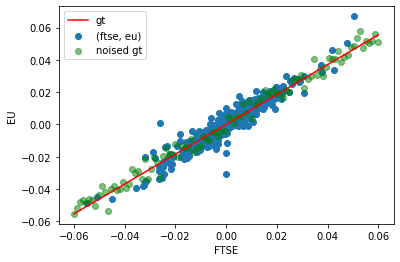

ground-truth variance:  1.717672603263054e-05


In [82]:
unstacked_corr = corr_matrix.unstack()
unstacked_corr['EU']
eu, ftse = Tensor(ist_df['EU'].to_numpy())[...,None], Tensor(ist_df['FTSE'].to_numpy())[...,None]
data = ch.linspace(-.06, .06, 100).reshape(100, 1)

ols = LinearRegression()
ols.fit(eu, ftse)
gt_var = (eu - ols.predict(ftse)).var(0)

ax = plt.subplot(1, 1, 1)
plt.plot(data, ols.predict(data), color='r', label='gt')
plt.scatter(ftse, eu, label='(ftse, eu)')
plt.scatter(data, Tensor(ols.predict(data)) + ch.sqrt(gt_var)*ch.randn(data.shape[0], 1), color='g', alpha = .5, label='noised gt')
ax.set_xlabel('FTSE')
ax.set_ylabel('EU')
plt.legend()
plt.show()

print('ground-truth variance: ', float(gt_var))

# Truncate Regression


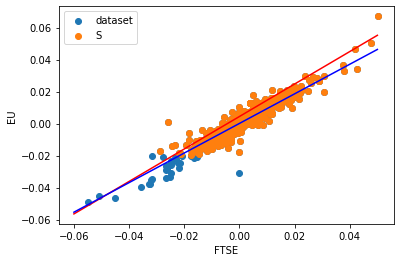

In [83]:
phi = oracle.Left(-.02)
indices = phi(eu).nonzero(as_tuple=False).flatten()

eu_trunc, ftse_trunc = eu[indices], ftse[indices]
trunc_ols = LinearRegression()
trunc_ols.fit(ftse_trunc, eu_trunc)
data = ch.linspace(-.06, .05, 100)[...,None]

ax = plt.subplot(1, 1, 1)
plt.scatter(ftse, eu, label='dataset')
plt.scatter(ftse_trunc, eu_trunc, label='S')
plt.plot(data, trunc_ols.predict(data), color='red')
plt.plot(data, ols.predict(data), color='blue')
ax.set_xlabel('FTSE')
ax.set_ylabel('EU')
plt.legend()
plt.show()

# Data Preprocessing
Select the performance results for the EM and EU indices. Since, the performance results are expressed in decimals (because they are percentages) and are extremely small, we standardize the data, so that are gradients aren't negatively influenced by the magnitude of the performance rates.

emp noise var:  tensor([2.6328e-05])


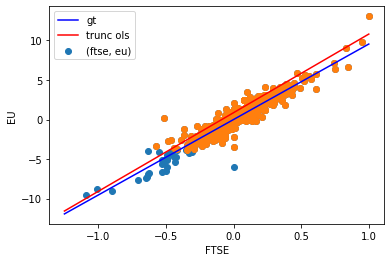

In [84]:
# scale dependent variable by sigma
emp_noise_var = (eu_trunc - trunc_ols.predict(ftse_trunc)).var(0)
print("emp noise var: ", emp_noise_var)

eu_trunc_emp_scaled = eu_trunc / ch.sqrt(emp_noise_var)
beta = LA.norm(ftse_trunc, dim=-1, ord=float('inf')).max()
ftse_trunc_norm = ftse_trunc / beta
ftse_norm = ftse / beta
eu_emp_scaled = eu / ch.sqrt(emp_noise_var)

emp_scaled_ols = LinearRegression()
emp_scaled_ols.fit(ftse_norm, eu_emp_scaled)

trunc_emp_scaled_ols = LinearRegression()
trunc_emp_scaled_ols.fit(ftse_trunc_norm, eu_trunc_emp_scaled)

data = np.linspace(-1.25, 1, 100).reshape(-1, 1)
ax = plt.subplot(1, 1, 1)
plt.scatter(ftse_norm, eu_emp_scaled, label='(ftse, eu)')
plt.scatter(ftse_trunc_norm, eu_trunc_emp_scaled)
plt.plot(data, emp_scaled_ols.predict(data), color='b', label='gt')
plt.plot(data, trunc_emp_scaled_ols.predict(data), color='r', label='trunc ols')
ax.set_xlabel('FTSE')
ax.set_ylabel('EU')
plt.legend()
plt.show()

# Set up Experiment
For storing the experiment's hyperparameters, we use [cox](https://github.com/MadryLab/cox), MadryLab's light-weight experimental design and analysis framework. 

In [36]:
args = Parameters({
    "bias": True,
    "bs": 10,
    "trials": 100,
    "steps": 1000,
    "out_dir": '/home/gridsan/stefanou/Regression/', 
    "table_name": 'results', 
    'tol': 1e-2,
    'n': 100,
})
EXP = 'Istanbul'
mse_loss = ch.nn.MSELoss()

# Create Store for Experiment Results

In [34]:
def run_trial(kwargs, X, y):
    """
    Runs a trial of a truncated regression experiment. Runs a maximum 
    of three trials of an experiment. The experiment terminates when either 
    the norm of teh score is less than 3e-1, or when three trials is up. After 
    three trials it returns the best truncated regression experiment.
    :param kwargs: keyword arguments for experiment 
    :param X: independent variable
    :param y: dependent variable
    :return: truncated regression experiment and time that experiment took
    """
    st = datetime.datetime.now()        
    # run procedure until get reasonable score
    attempt, score, best_trunc_reg = 0, None, None
    while (score is None or score.norm() > 3e-1) and attempt < 3:
        trunc_reg = TruncatedRegression(**kwargs)
        trunc_reg.fit(X, y)
        grad = trunc_reg.score()
        if score is None or grad.norm() < score.norm(): 
            score, best_trunc_reg = grad, trunc_reg
        attempt += 1
    total_time = int((datetime.datetime.now() - st).total_seconds())
    return best_trunc_reg, total_time  

# Run Procedure

In [74]:
# ground_truth parameters
gt = LinearRegression() 
gt.fit(ftse, eu)
gt_params = Tensor(np.concatenate([gt.coef_, np.expand_dims(gt.intercept_, 0)], axis=1))
gt_var = Tensor(np.var(gt.predict(ftse) - eu.numpy(), 0))

C = [-.05, -.04, -.03, -.02, -.01, 0, .01, .02, .03]
for i in range(args.trials):
    # create store
    store = Store(args.out_dir + EXP)
    store.add_table(TABLE_NAME, { 
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_r2': float,
        'unknown_time': int,
        'ols_r2': float, 
        'ols_param_mse': float,
        'ols_var_l1': float,
#         'trunc_reg_param_mse': float, 
#         'trunc_var_l1': float,
        'alpha': float, 
        'c': float, 
        'num_samples': int,
    })
    
    for c in C: 
        # truncate
        phi = oracle.Left(c)
        indices = phi(eu).eq(1).flatten()
        x_trunc, y_trunc = ftse[indices], eu[indices].float()
        # add survival probability to hyperparameters
        alpha = Tensor([x_trunc.shape[0] / ftse.shape[0]])
        print("alpha: ", alpha)
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        emp_noise_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[...,None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        
        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(eu.flatten(), ols.predict(ftse).flatten()), 
            'ols_var_l1': ch.abs(emp_noise_var - gt_var),
            'ols_param_mse': mse_loss(ols_params, gt_params.flatten()),
        })
        
        val = int(.1*x_trunc.size(0))
        
        beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
        x_trunc_norm = x_trunc / beta
        
        # scale by the known noise variance 
        y_trunc_scaled = y_trunc / ch.sqrt(gt_var)
        phi_scaled = oracle.Left(phi.left / ch.sqrt(gt_var))
        
        # standardize noised by actual noise variance
        known_kwargs = { 
            'phi': phi_scaled, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        
        # truncated linear regression with known noise variance using empirical noise variance
        known_trunc_reg, total_time = run_trial(known_kwargs, x_trunc_norm, y_trunc_scaled) 
        
        with ch.no_grad():       
            w, w0 = (known_trunc_reg.weight * ch.sqrt(gt_var)) / beta, known_trunc_reg.intercept * ch.sqrt(gt_var) 
            known_params = ch.cat([w.flatten(), w0])
            # known results
            store[TABLE_NAME].update_row({
                'known_r2': r2_score(eu.flatten(), ftse@w + w0), 
                'known_param_mse': mse_loss(known_params, gt_params.flatten()),
                'known_time': total_time, 
            })
            
        
        phi_emp_scaled = oracle.Left(phi.left / ch.sqrt(emp_noise_var))
        y_trunc_emp_scaled = y_trunc / ch.sqrt(emp_noise_var)
            
        # standardize noised by actual noise variance
        unknown_kwargs = { 
            'phi': phi_emp_scaled, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': True, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        
        # truncated linear regression with unknown noise variance using empirical noise variance
        unknown_trunc_reg, total_time = run_trial(unknown_kwargs, x_trunc_norm, y_trunc_emp_scaled)  
        
        with ch.no_grad():      
            w, w0 = (unknown_trunc_reg.weight * unknown_trunc_reg.variance * ch.sqrt(emp_noise_var)) / beta, unknown_trunc_reg.intercept * ch.sqrt(emp_noise_var) * unknown_trunc_reg.variance 
            unknown_params = ch.cat([w, w0]).flatten()
            # known results
            store[TABLE_NAME].update_row({
                'unknown_r2': r2_score(eu.flatten(), ftse@w + w0), 
                'unknown_param_mse': mse_loss(unknown_params, gt_params.flatten()),
                'unknown_time': total_time, 
                'unknown_var_l1': ch.abs(unknown_trunc_reg.variance * emp_noise_var - gt_var)
            })
            

        store[TABLE_NAME].append_row({ 
            'alpha': float(alpha), 
            'c': c,    
            'num_samples': x_trunc.size(0),
        })
            
    # close current store
    store.close()

Logging in: /home/gridsan/stefanou/Regression/Istanbul/02a8e2d9-d6c3-4a78-8fd2-4d958c5504a6
alpha:  tensor([1.])
Iteration: 0.0 | Score: [0.040692128241062164]
Iteration: 1.0 | Score: [0.004807664547115564]
Iteration: 0.0 | Score: [0.06749777495861053, 0.16827787458896637]
Iteration: 1.0 | Score: [-0.023990018293261528, 0.6377436518669128]
Iteration: 2.0 | Score: [-0.04438327997922897, 0.684579610824585]
Iteration: 3.0 | Score: [0.0418664924800396, 0.3566693365573883]
Iteration: 4.0 | Score: [0.058221686631441116, 0.384902685880661]
Iteration: 5.0 | Score: [0.0827915146946907, 0.37640380859375]
Iteration: 6.0 | Score: [0.11466789990663528, -0.4554339349269867]
Iteration: 7.0 | Score: [0.027174564078450203, 0.5875524878501892]
Iteration: 8.0 | Score: [0.05819310247898102, 0.4051353335380554]
Iteration: 9.0 | Score: [0.09707382321357727, 0.09554917365312576]
Iteration: 10.0 | Score: [0.06236066669225693, 0.38057786226272583]
Iteration: 0.0 | Score: [-0.13098345696926117, 1.28511285781860

Iteration: 1.0 | Score: [-0.12644265592098236, 1.9527199268341064]
Iteration: 2.0 | Score: [-0.04297972843050957, 1.475003719329834]
Iteration: 3.0 | Score: [-0.056022655218839645, 1.8140331506729126]
Iteration: 4.0 | Score: [-0.12015459686517715, 1.9689826965332031]
Iteration: 5.0 | Score: [-0.25766631960868835, 2.813993453979492]
Iteration: 6.0 | Score: [-0.19666007161140442, 2.526919364929199]
Iteration: 7.0 | Score: [0.02139836736023426, 1.2916510105133057]
Iteration: 8.0 | Score: [-0.006330035626888275, 1.5405024290084839]
Iteration: 9.0 | Score: [-0.09368233382701874, 1.922817349433899]
Iteration: 10.0 | Score: [-0.13192732632160187, 2.0869877338409424]
Iteration: 0.0 | Score: [-0.06558716297149658, 0.46163493394851685]
Iteration: 1.0 | Score: [-2.254894971847534, 7.208871364593506]
Iteration: 2.0 | Score: [-0.32551291584968567, 4.881682395935059]
Iteration: 3.0 | Score: [-0.29787999391555786, 2.6205129623413086]
Iteration: 4.0 | Score: [-0.184859037399292, 1.0930498838424683]
It

Iteration: 1.0 | Score: [-0.7903320789337158]
Iteration: 2.0 | Score: [-0.6195402145385742]
Iteration: 3.0 | Score: [-0.7007160186767578]
Iteration: 4.0 | Score: [-0.7074787616729736]
Iteration: 5.0 | Score: [-0.6653196811676025]
Iteration: 6.0 | Score: [-0.556955099105835]
Iteration: 7.0 | Score: [-0.7286679744720459]
Iteration: 8.0 | Score: [-0.6488375663757324]
Iteration: 9.0 | Score: [-0.6058657169342041]
Iteration: 10.0 | Score: [-0.6866168975830078]
Iteration: 0.0 | Score: [0.5011424422264099, -3.8230905532836914]
Iteration: 1.0 | Score: [9.061056137084961, -120.19387817382812]
Iteration: 2.0 | Score: [-8.849183082580566, 40.9155158996582]
Iteration: 3.0 | Score: [-3.9533708095550537, 28.791812896728516]
Iteration: 4.0 | Score: [-3.1601157188415527, 24.469772338867188]
Iteration: 5.0 | Score: [-8.849183082580566, 40.9155158996582]
Iteration: 6.0 | Score: [-3.5802457332611084, 26.82720184326172]
Iteration: 7.0 | Score: [-4.143852710723877, 29.759605407714844]
Iteration: 8.0 | Scor

Iteration: 10.0 | Score: [0.13491560518741608, 0.12825915217399597]
alpha:  tensor([0.9440])
Iteration: 0.0 | Score: [0.1523316651582718]
Iteration: 1.0 | Score: [0.055861152708530426]
Iteration: 2.0 | Score: [0.09552676230669022]
Iteration: 3.0 | Score: [0.14172102510929108]
Iteration: 4.0 | Score: [0.11944190412759781]
Iteration: 5.0 | Score: [0.05065559223294258]
Iteration: 6.0 | Score: [0.06399981677532196]
Iteration: 7.0 | Score: [0.07180214673280716]
Iteration: 8.0 | Score: [0.1125255674123764]
Iteration: 9.0 | Score: [0.11964856088161469]
Iteration: 10.0 | Score: [0.09125904738903046]
Iteration: 0.0 | Score: [0.1995425969362259, -0.19351163506507874]
Iteration: 1.0 | Score: [0.21054111421108246, -0.15733987092971802]
Iteration: 2.0 | Score: [0.12112991511821747, 0.12848010659217834]
Iteration: 3.0 | Score: [0.22552664577960968, -0.3307725191116333]
Iteration: 4.0 | Score: [0.10204975306987762, 0.18692843616008759]
Iteration: 5.0 | Score: [0.18135124444961548, -0.1334406733512878

Iteration: 4.0 | Score: [-2.3101389408111572, 6.944322109222412]
Iteration: 5.0 | Score: [-1.289412260055542, 5.207177639007568]
Iteration: 6.0 | Score: [0.30835679173469543, -1.081761360168457]
Iteration: 7.0 | Score: [-0.822776198387146, 3.566195011138916]
Iteration: 8.0 | Score: [0.30562877655029297, -1.0783823728561401]
Iteration: 9.0 | Score: [0.3898680806159973, -1.5453909635543823]
Iteration: 10.0 | Score: [0.30539509654045105, -1.2366832494735718]
Iteration: 0.0 | Score: [0.031003419309854507, 0.9970691800117493]
Iteration: 1.0 | Score: [-0.6227959394454956, 6.480045318603516]
Iteration: 2.0 | Score: [-0.5218948125839233, 5.904865264892578]
Iteration: 3.0 | Score: [-1.0359946489334106, 8.162693977355957]
Iteration: 4.0 | Score: [-0.7611828446388245, 7.00898551940918]
Iteration: 5.0 | Score: [-0.4693971872329712, 5.671421527862549]
Iteration: 6.0 | Score: [-0.7674935460090637, 6.983092308044434]
Iteration: 7.0 | Score: [-1.75383460521698, 10.903183937072754]
Iteration: 8.0 | Sco

Iteration: 1.0 | Score: [-0.03148926421999931, -0.1878659576177597]
Iteration: 2.0 | Score: [-0.05681410804390907, -2.0574498176574707]
Iteration: 3.0 | Score: [0.05845198407769203, -0.18662504851818085]
Iteration: 4.0 | Score: [-0.03063025511801243, 0.09558975696563721]
Iteration: 5.0 | Score: [-0.00015607813838869333, 0.29331690073013306]
Iteration: 6.0 | Score: [-0.024761654436588287, 0.5347914099693298]
Iteration: 7.0 | Score: [-0.03224988654255867, -0.08719321340322495]
Iteration: 8.0 | Score: [-0.025418661534786224, -0.4782807230949402]
Iteration: 9.0 | Score: [-0.04289368912577629, -0.48485690355300903]
Iteration: 10.0 | Score: [-0.013140774331986904, -0.8294877409934998]
alpha:  tensor([0.9440])
Iteration: 0.0 | Score: [0.08277676999568939]
Iteration: 1.0 | Score: [0.09898477792739868]
Iteration: 2.0 | Score: [0.010942809283733368]
Iteration: 3.0 | Score: [0.08120459318161011]
Iteration: 4.0 | Score: [0.06498965620994568]
Iteration: 5.0 | Score: [0.040252283215522766]
Iteration

Iteration: 3.0 | Score: [-0.5265019536018372, 4.304928779602051]
Iteration: 4.0 | Score: [-0.350251704454422, 3.9426493644714355]
Iteration: 5.0 | Score: [-0.28044676780700684, 3.7327561378479004]
Iteration: 6.0 | Score: [-0.4039038419723511, 4.097947597503662]
Iteration: 7.0 | Score: [0.0038976185023784637, 3.174264430999756]
Iteration: 8.0 | Score: [-0.48250988125801086, 4.011946678161621]
Iteration: 9.0 | Score: [-0.38746216893196106, 4.140074253082275]
Iteration: 10.0 | Score: [-2.879988193511963, 7.711182117462158]
alpha:  tensor([0.1959])
Iteration: 0.0 | Score: [0.0930759459733963]
Iteration: 1.0 | Score: [-0.14251667261123657]
Iteration: 2.0 | Score: [-0.21006599068641663]
Iteration: 3.0 | Score: [-0.14303556084632874]
Iteration: 4.0 | Score: [-0.1763043999671936]
Iteration: 5.0 | Score: [-0.18352466821670532]
Iteration: 6.0 | Score: [-0.1677359640598297]
Iteration: 7.0 | Score: [-0.17048859596252441]
Iteration: 8.0 | Score: [-0.1601543128490448]
Iteration: 9.0 | Score: [-0.173

# Results

In [75]:
reader = CollectionReader(args.out_dir + EXP)
results = reader.df(TABLE_NAME)
results.head()

100%|██████████| 3/3 [00:00<00:00, 103.62it/s]


,known_r2,known_param_mse,known_time,unknown_param_mse,unknown_var_l1,unknown_r2,unknown_time,ols_r2,ols_param_mse,ols_var_l1,alpha,c,num_samples,exp_id
0,0.900485,0.000009,0,0.004971,0.000006,0.891067,3,0.900531,0.000000,3.131208e-08,1.000000,-0.05,536,02a8e2d9-d6c3-4a78-8fd2-4d958c5504a6
1,0.900164,0.000159,0,0.000028,0.000006,0.900433,1,0.900509,0.000011,3.462264e-08,0.994403,-0.04,533,02a8e2d9-d6c3-4a78-8fd2-4d958c5504a6
2,0.899972,0.000047,0,0.000196,0.000007,0.900097,1,0.900136,0.000137,2.135690e-06,0.977612,-0.03,524,02a8e2d9-d6c3-4a78-8fd2-4d958c5504a6
3,0.900387,0.000007,0,0.000080,0.000008,0.900277,3,0.899636,0.000318,2.291896e-06,0.944030,-0.02,506,02a8e2d9-d6c3-4a78-8fd2-4d958c5504a6
4,0.900240,0.000034,0,0.000373,0.000009,0.899821,3,0.896738,0.000950,4.175437e-06,0.830224,-0.01,445,02a8e2d9-d6c3-4a78-8fd2-4d958c5504a6


In [88]:
results[results['c'] == 0.01]

,known_r2,known_param_mse,known_time,unknown_param_mse,unknown_var_l1,unknown_r2,unknown_time,ols_r2,ols_param_mse,ols_var_l1,alpha,c,num_samples,exp_id
6,0.898662,0.000115,0,0.252955,0.000008,-0.457149,3,0.820404,0.005838,0.000002,0.195896,0.01,105,02a8e2d9-d6c3-4a78-8fd2-4d958c5504a6
6,0.898984,0.000078,0,0.008296,0.000002,0.720020,3,0.820404,0.005838,0.000002,0.195896,0.01,105,0adbc906-8adb-45e5-80a7-6b2d15f252b5
6,0.897028,0.000158,0,0.179433,0.000005,-0.206520,3,0.820404,0.005838,0.000002,0.195896,0.01,105,d14ee26c-e715-4f4a-a4da-3a4228a9bcf0


# Plot Results

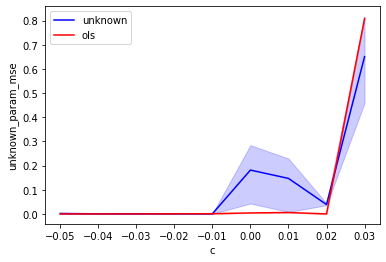

In [85]:
# plot results for regression parameter MSE
sns.lineplot(data=results, x='c', y='unknown_param_mse', label='unknown', color='blue')
sns.lineplot(data=results, x='c', y='ols_param_mse', label='ols', color='red')
# ax = sns.lineplot(data=results, x='c', y='known_param_mse', label='known', color='orange')
ax.set(xlabel='Truncation Parameter C', ylabel='L2 Distance')
plt.show()

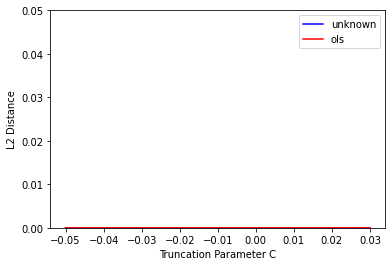

In [89]:
# plot results for regression noise variance MSE
sns.lineplot(data=results, x='c', y='unknown_var_l1', label='unknown', color="blue")
ax = sns.lineplot(data=results, x='c', y='ols_var_l1', label='ols', color="red")
ax.set(xlabel='Truncation Parameter C', ylabel='L2 Distance')
ax.set(ylim=(0, .05))
plt.show()